In [32]:
import numpy as np
from qiskit import*
from scipy.linalg import expm # exponentiation of matrix.

In [3]:
sigma_X = np.matrix([[0, 1], [1, 0]])
sigma_Y = np.matrix([[0,-1j],[1j,0]])
sigma_Z = np.matrix([[0,1],[1,0]])
def Psi_ansatz(alpha,theta,state_initial):
    return alpha * np.exp(-(1j/2)*theta*sigma_X)*state_initial

def Psi_tilde(theta,state_initial):
    return np.exp(-(1j/2)*theta*Pauli_X)*state_initial

### Circuit for $M_{ij}$

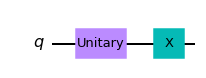

In [41]:
qc = QuantumCircuit(1)

theta_initial = np.pi

# Defining the U1 gate.
def U_1(theta):
     return expm(-1j*theta*0.5*sigma_X)
    
P_1 = sigma_X # P_1 is sigma_X in our case.     
    
    
qc.unitary(U_1(theta_initial),0)
qc.x(0)
qc.draw("mpl")

### Circuit for $V_{j}$